In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Adversarial attacks and robustness for quantum machine learning
===============================================


This demo is based on the paper *A Comparative Analysis of Adversarial
Robustness for Quantum and Classical Machine Learning Models* by M.
Wendlinger, K. Tscharke and P. Debus, which dives into the world of
adversarial attacks on quantum computers to find relations to classical
adversarial machine learning. In the following, we briefly cover the
necessary theoretical baselines of adversarial attacks on classification
networks before giving a hands-on example of how to construct such an
attack and how we can make QML models more robust. Let's go!

![](../_static/demonstration_assets/adversarial_attacks_QML/QAML_overview.png){.align-center
width="80.0%"}


# What are adversarial attacks?

Adversarial attacks are small, carefully crafted perturbations to input
data that lead to high rates of misclassification for machine learning
models, while the data seems to be identical to the original for human
observers. In particular, images are sensitive to this type of attack,
as small manipulations of the pixels can fool a classifier without any
changes being visible to humans. A typical example of an adversarial
attack is shown in the picture above, where an image of a panda is
manipulated by adding a small noise to each pixel. The original image is
correctly classified as \"Panda,\" while the image with tiny
manipulations is falsely classified as \"Gibbon\" (the noise is
magnified in the figure so we can actually see it). This example is
adapted from a famous paper showing the vulnerability of classical
machine learning models to adversarial attacks.

Mathematically, the goal of an (untargeted) attack is to achieve a
misclassification of the model such that a sample $x$ leads to a
predicted label $y' \neq y$ that is not the true label $y.$ This is
achieved by finding the perturbation $\delta\in\Delta$ to the original
input that maximizes the loss of the true class. For a loss function
$\mathcal{L},$ a model $f: \mathbb{R}^{D} \to \mathbb{R}^K$ (mapping
$D$-dimensional input to
[softmax](https://en.wikipedia.org/wiki/Softmax_function) probability
scores of $K$ classes with model parameters $\theta^*$), the objective
of the untargeted attack is:

$$\delta \equiv \; \underset{\delta^{\prime} \in \Delta}{\operatorname{argmax}} \;\mathcal{L}\left(f\left(x+\delta^{\prime} ; \theta^*\right), y\right).$$

Later, when we show how to actually construct such an attack, we will
revisit this equation. For an adversarial attack to be considered
useful, it must hold that the modifications to the input elements are
imperceptible, i.e. that
$\Delta=\{\delta \in \mathbb{R}^{D}: \| \delta\|_{\infty} \le \varepsilon\},$
where $\varepsilon$ is some small bound, typically below $0.1.$


# Why are adversarial attacks dangerous?

Machine learning (ML) is becoming essential in many security-critical
applications, for example in
[cybersecurity](https://arxiv.org/abs/1901.03407), the [medical
sector](https://arxiv.org/abs/1606.05718), or [autonomous
vehicles](https://arxiv.org/abs/1604.07316). In cybersecurity, ML models
are used, amongst others, for malware detection or the prevention of
attacks on networks. Given their critical roles, any successful attack
of these ML models can lead to severe consequences, ranging from
financial losses and privacy violations to threats to human life. As we
have seen above, adversarial attacks are imperceptible to humans, and
hence difficult to detect. For this reason, it is essential that ML
models in security-critical applications are robust against these types
of attacks.

[Quantum machine learning
(QML)](%5B/whatisqml%5D(https://pennylane.ai/qml/whatisqml/)) has been
shown to have theoretical advantages over classical ML methods and is
becoming increasingly popular. However, first works in this direction
suggest that QML suffers from the same vulnerabilities as classical ML.
How the vulnerability of QML models relates to classical models and how
robust the models are in comparison is evaluated in. But enough talk,
let's see how we can actually attack a QML model!


# Let's see this in action!

## Setting up the environment

For this tutorial, we will use the PennyLane
`~pennylane.qnn.TorchLayer`{.interpreted-text role="class"} class to
perform circuit operations and optimizations with the PyTorch backend.
Thus, we need to import the torch library alongside PennyLane:


In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt

# Visualization of the dataset

As in the paper, we make use of the
[PlusMinus](https://pennylane.ai/datasets/single-dataset/plus-minus)
dataset (available via [PennyLane
Datasets](https://pennylane.ai/datasets/)), which serves as a good
baseline for evaluating a QML image classification model's ability to
find useful features in the input. It also allows us to define the
usefulness of attacks on the QML model while being low-dimensional
enough to perform scalable training (more info on the dataset can be
found in). It consists of four classes of $16\times16$ pixel grayscale
images which show one of the four symbols $\{+,-,\vdash,\dashv\}.$ Below
we visualize one sample of each class to get an understanding of the
dataset.

The data can be loaded directly from [PennyLane
Datasets](https://pennylane.ai/datasets/) for easy integration into
PennyLane circuits and optimization code.


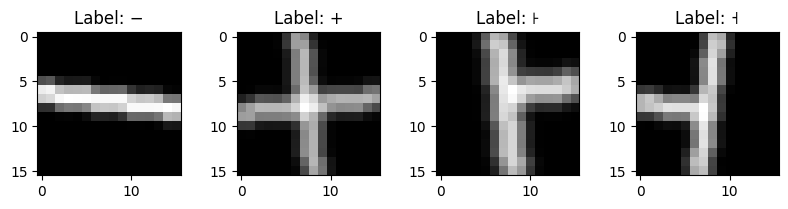

In [3]:
# podemos usar o conjunto de dados hospedado no PennyLane
[pm] = qml.data.load('other', name='plus-minus')

X_train = pm.img_train  # shape (1000,16,16)
X_test = pm.img_test  # shape (200,16,16)
Y_train = pm.labels_train  # shape (1000,)
Y_test = pm.labels_test  # shape (200,)

# mostra uma imagem de cada classe (nos conjuntos de treinamento e teste, as imagens são permutadas aleatoriamente)
x_vis = [
    (X_train[Y_train == 0])[0],
    (X_train[Y_train == 1])[0],
    (X_train[Y_train == 2])[0],
    (X_train[Y_train == 3])[0],
]
y_vis = [0, 1, 2, 3]


# mais tarde, quando treinamos o modelo, incluímos as previsões também, então vamos apenas adicionar a funcionalidade aqui
def visualize_data(x, y, pred=None):
    n_img = len(x)
    labels_list = ["\u2212", "\u002b", "\ua714", "\u02e7"]
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(labels_list[y[i]]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(labels_list[y[i]], labels_list[pred[i]]))
    plt.tight_layout(w_pad=2)
    # plt.show()


visualize_data(x_vis, y_vis)

# Building the QML circuit for classification

Usaremos um esquema
`data-reuploading <tutorial_data_reuploading_classifier>`{.interpreted-text
role="doc"}  para codificar os 256 pixels de entrada no espaço latente
do classificador quântico. Para esse fim, o modelo
`~pennylane.StronglyEntanglingLayers`{.interpreted-text role="class"}
fornece uma estrutura fácil de usar para o design do circuito. A
saída do nosso classificador é um vetor quadridimensional resultante de
observáveis ​​Pauli Z ao longo dos quatro primeiros qubits. Essas saídas
(pontuações de probabilidade não normalizadas --- ou seja, logits) são então usadas na
[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
função para otimizar os parâmetros do modelo. Junto com a integração PyTorch
mencionada acima, o código do classificador se parece com o
seguinte:

In [ ]:
#### Hyperparameters ####
input_dim = 256
num_classes = 4
num_layers = 32
num_qubits = 8
num_reup = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes 
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }


        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cpu


# Training the classifier

O conjunto 'teste' será usado como validação em cada etapa do treinamento para verificar as capacidades de generalização do nosso classificador.


In [5]:
#### Hyperparameters ####
learning_rate = 0.1
epochs = 4
batch_size = 20

# usamos um subconjunto dos dados de treinamento e validação para este tutorial para acelerar o treinamento
feats_train = torch.from_numpy(X_train[:200]).reshape(200, -1).to(device)
feats_test = torch.from_numpy(X_test[:50]).reshape(50, -1).to(device)
labels_train = torch.from_numpy(Y_train[:200]).to(device)
labels_test = torch.from_numpy(Y_test[:50]).to(device)
num_train = feats_train.shape[0]

# inicializar o modelo, a função de perda e o algoritmo de otimização (otimizador de Adam)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


# gerar lotes permutados aleatoriamente para acelerar o treinamento
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# exibir precisão e perda após cada época (para acelerar o tempo de execução, faça isso apenas para as primeiras 100 amostras)
def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# otimizar os parâmetros do modelo para um determinado número de épocas
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

Starting training loop for quantum variational classifier (8 qubits, 32 layers)...
Epoch 0/4 | Approx Cost (train): 1.3883215 | Cost (val): 1.3875421 | Approx Acc train: 0.1600000 | Acc val: 0.1200000
Epoch 1/4 | Approx Cost (train): 1.2474121 | Cost (val): 1.2367991 | Approx Acc train: 0.8200000 | Acc val: 0.8800000
Epoch 2/4 | Approx Cost (train): 1.1586236 | Cost (val): 1.1770440 | Approx Acc train: 0.9800000 | Acc val: 0.9600000
Epoch 3/4 | Approx Cost (train): 1.0625679 | Cost (val): 1.0833577 | Approx Acc train: 0.9600000 | Acc val: 0.9800000
Epoch 4/4 | Approx Cost (train): 1.0000771 | Cost (val): 1.0048925 | Approx Acc train: 1.0000000 | Acc val: 0.9800000


# Evaluation - benign data


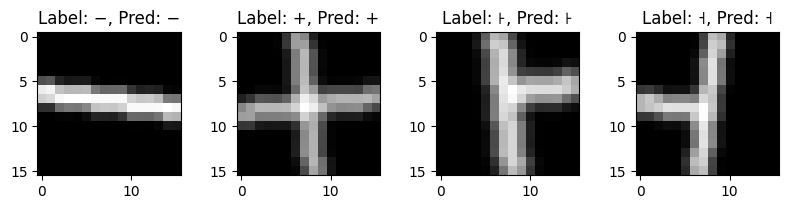

In [6]:
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(4, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualize_data(x_vis, y_vis, benign_class_output)

# Let's break stuff!

As described before, the mathematical notation for an adversarial attack
is as follows:

$$\delta \equiv \; \underset{\delta^{\prime} \in \Delta}{\operatorname{argmax}} \;\mathcal{L}\left(f\left(x+\delta^{\prime} ; \theta^*\right), y\right).$$

Esta equação pode ser resumida em uma receita simples passo a passo. Em termos básicos, realizamos uma passagem para frente e para trás pelo modelo e função de perda (assim como fazemos durante o treinamento) para as amostras específicas para as quais queremos encontrar perturbações. A diferença para etapas de treinamento é que os gradientes que calculamos são **com relação aos recursos de entrada** das amostras de dados. Usando esses gradientes, encontramos a direção da subida na função de perda (pois queremos forçar altas perdas, ou seja, desempenho ruim do modelo para as amostras específicas). Finalmente, recortamos o delta (perturbações), de modo que fiquem dentro do limite epsilon que definimos de antemão (este é apenas um hiperparâmetro que limita a força do ataque). Todas essas etapas podem ser vistas no código abaixo:


In [7]:
# simple implementation of projected gradient descent (PGD) attack (without randomized starting points — cf. BIM)
# for an introduction to PGD, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        # forward & backward pass through the model, accumulating gradients
        l = loss(torch.stack(outputs), labels)
        l.backward()

        # use gradients with respect to inputs and clip the results to lie within the epsilon boundary
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# Evaluation --- model under attack


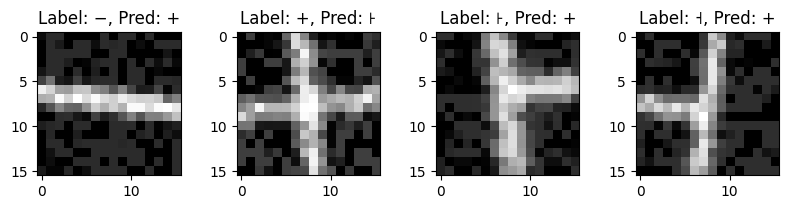

In [8]:
perturbations = PGD(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

Podemos ver o efeito devastador de um ataque PGD (descida de gradiente projetada) simples usando uma força de perturbação $\varepsilon=0,1,$ onde
o modelo classifica incorretamente cada uma das quatro amostras que usamos para
visualização do conjunto de dados. Para humanos, as imagens ainda são muito
facilmente classificáveis, as perturbações parecem principalmente ruído aleatório
adicionado às imagens. No geral, a precisão do modelo para o
conjunto de trens perturbado diminui para cerca de $0,1,$ então quase todas as amostras
do conjunto de dados são classificadas incorretamente!

Usando o código acima, você pode tentar o ataque por conta própria e verificar quais
amostras são mais robustas contra ataques e quais rótulos o modelo
(erroneamente) atribui aos dados. A questão restante é: podemos nos defender
contra tais ataques? Como podemos treinar nossos modelos (QML) para serem mais
robustos contra ataques adversários? Este é um campo de muita pesquisa ativa
e, em geral, um problema muito difícil de resolver para diferentes tipos
de ataques, arquiteturas de modelos e dados de entrada, mas uma abordagem muito simples
é dada abaixo.

# Increasing the robustness of QML models

A maneira mais fácil de tornar nosso modelo ciente de pequenas modificações é
simplesmente incluir as imagens perturbadas no conjunto de dados de treinamento (isso pode
ser visto como aumento de dados e geralmente é feito em aprendizado de máquina clássico
usando ruído). Dessa forma, espera-se que o modelo seja mais robusto
contra amostras que foram construídas usando o mesmo ataque sem
mudar nada na arquitetura do modelo em si; esse método é
chamado **(re)treinamento adversário**.


In [9]:
adv_dataset = (
    PGD(model=qml_model, feats=feats_train[:20], labels=labels_train[:20], epsilon=0.1)
    + feats_train[:20]
)

feats_retrain = torch.cat((feats_train, adv_dataset))
labels_retrain = torch.cat((labels_train, labels_train[:20]))
epochs_retraining = 2

for ep in range(0, epochs_retraining):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=2)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_retrain[batch_ind[it]]
        labels_train_batch = labels_retrain[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs_retraining, max_ep=2)

Epoch 0/2 | Approx Cost (train): 1.0000771 | Cost (val): 1.0048925 | Approx Acc train: 1.0000000 | Acc val: 0.9800000
Epoch 1/2 | Approx Cost (train): 0.9361414 | Cost (val): 0.9478188 | Approx Acc train: 0.9600000 | Acc val: 0.9600000
Epoch 2/2 | Approx Cost (train): 0.9086213 | Cost (val): 0.9238126 | Approx Acc train: 0.9800000 | Acc val: 0.9600000


# Evaluation of the retrained model


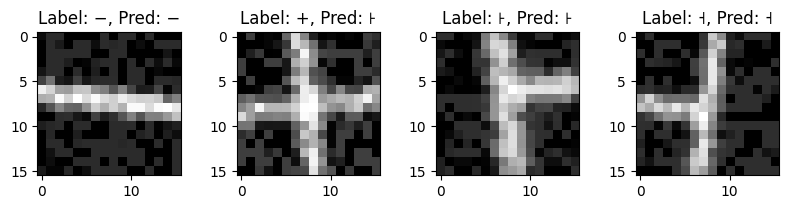

In [10]:
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

We can see that the model now correctly classifies three out of the four
perturbed input images. As before, you can adapt the code above and test
the retrained model for the whole dataset to see how much the accuracy
under attack improves overall.


# Conclusion

Nesta demonstração, vimos como executar ataques adversários em modelos de classificação
variacional quântica. As imagens perturbadas resultantes (que
--- para humanos --- ainda se assemelham muito às originais) resultam em
grandes taxas de classificação incorreta dos modelos QML, mostrando a
vulnerabilidade de tais modelos a ataques adversários. Consequentemente, nós
mostramos uma possibilidade de aumentar a robustez adversária usando
retreinamento adversário, o que levou o modelo sob ataque a ter um
desempenho melhor.

Embora esse método pareça útil, é preciso observar que essa é uma
abordagem muito básica (basta incluir as imagens perturbadas no conjunto de trens,
duh!) e pode não funcionar igualmente bem para um ataque diferente ou valores epsilon
ligeiramente alterados. Existem abordagens (por exemplo, usando a regularização
de Lipschitz, conforme mostrado em) que têm o potencial de ser mais eficazes
no aumento da robustez, mas esse ainda é um campo de pesquisa
em andamento, e muitas abordagens diferentes estão esperando para serem descobertas!